# Historical Australian temperature and rainfall anomalies  
This script is intended to read temperature and rainfall files from CMIP6 historical models.  
It will mask out all areas except for Australia and Eastern Australia. 
It will calulate anomalies on a monthly and seasonal basis and plot them as a time series.
It will also produce a time averaged map of the australian region with gridlines and labels etc.

Lets start by making this script for just one file and then I'll try calling this script in another notebook which loops over all the different historical model run files. 

In [1]:
# load all the packages I will need
import xarray as xr, matplotlib.pyplot as plt, numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????

In [2]:
# load in data files (I need to figure out how to loop over models and add in multiple files)
pr_ds = xr.open_dataset('/g/data/lp01/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/pr/gr1.5/v20181126/pr_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gr1.5_185001-201412.nc')
ts_ds = xr.open_dataset('/g/data/lp01/CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Amon/ts/gr1.5/v20181126/ts_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gr1.5_185001-201412.nc')

In [3]:
# import land fraction data
url = 'http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/fx/atmos/fx/r0i0p0/latest/sftlf/sftlf_fx_ACCESS1-3_historical_r0i0p0.nc'
landfrac = xr.open_dataset(url).sftlf

In [4]:
# change units 
pr = pr_ds.pr *86400 #convert units to mm/day
ts = ts_ds.ts - 273 # convert units from K to C

In [5]:
# here I select the Australia region and then mask out the ocean
pr_aus = pr.sel(lat=slice(-50,-5), lon=slice(110,160)) # these two lines select out a box containing australia
ts_aus = ts.sel(lat=slice(-50,-5), lon=slice(110,160))

# these two lines replace any ocean grid sections with nan so only land sections have a value
pr_aus = pr_aus.where(landfrac>0) 
ts_aus = ts_aus.where(landfrac>0)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(-0.05, 0, 'Latitude')

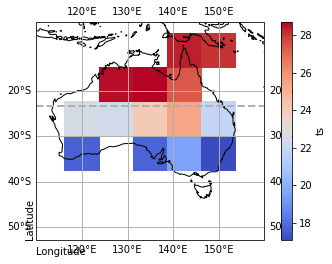

In [6]:
# just testing that the land masking is working.  The resolution is uper low and bad though and idk why really but try using Jo's other dataset first before getting too stressed. 
ax = plt.axes(projection=ccrs.PlateCarree()) # plot results with coastlines

ts_aus.mean(dim='time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.coastlines(resolution='50m')
ax.set_extent([110,160,-50,-5]) # sets axis bounds to show only australia region lon, lon, lat, lat
# add on grid lines for longitude and latitude at specified range and spacing
ax.gridlines(xlocs=range(110,160,10), ylocs=range(-50,-10,10),draw_labels=False) 
ax.gridlines(xlocs=range(110,160,10), ylocs=range(-50,-10,10),draw_labels=True)
# add in different grid lines for tropics
tropics = ax.gridlines(ylocs=[-66.5,-23.43691,23.43691,66.5],draw_labels=False,linewidth=2,linestyle='--', edgecolor='dimgrey')
tropics.xlines=False

#labels for latitude and longitude
ax.text(0,-0.07,'Longitude', transform=ax.transAxes, ha='left')
ax.text(-0.05,0,'Latitude', transform=ax.transAxes, rotation='vertical', va='bottom')

In [7]:
# group the data into months
pr_aus_mon = pr_aus.groupby('time.month')
ts_aus_mon = ts_aus.groupby('time.month')
# calculate the mean climatology along each month for the time period 1850-1900 
pr_aus_clim = pr_aus.sel(time=slice('1850-01','1900-12')).groupby('time.month').mean(dim='time')
ts_aus_clim = ts_aus.sel(time=slice('1850-01','1900-12')).groupby('time.month').mean(dim='time')

In [8]:
# caclulate the anomalies for each month
pr_anom_mon = (pr_aus_mon - pr_aus_clim)
ts_anom_mon = (ts_aus_mon - ts_aus_clim)



(-3.0, 4.0)

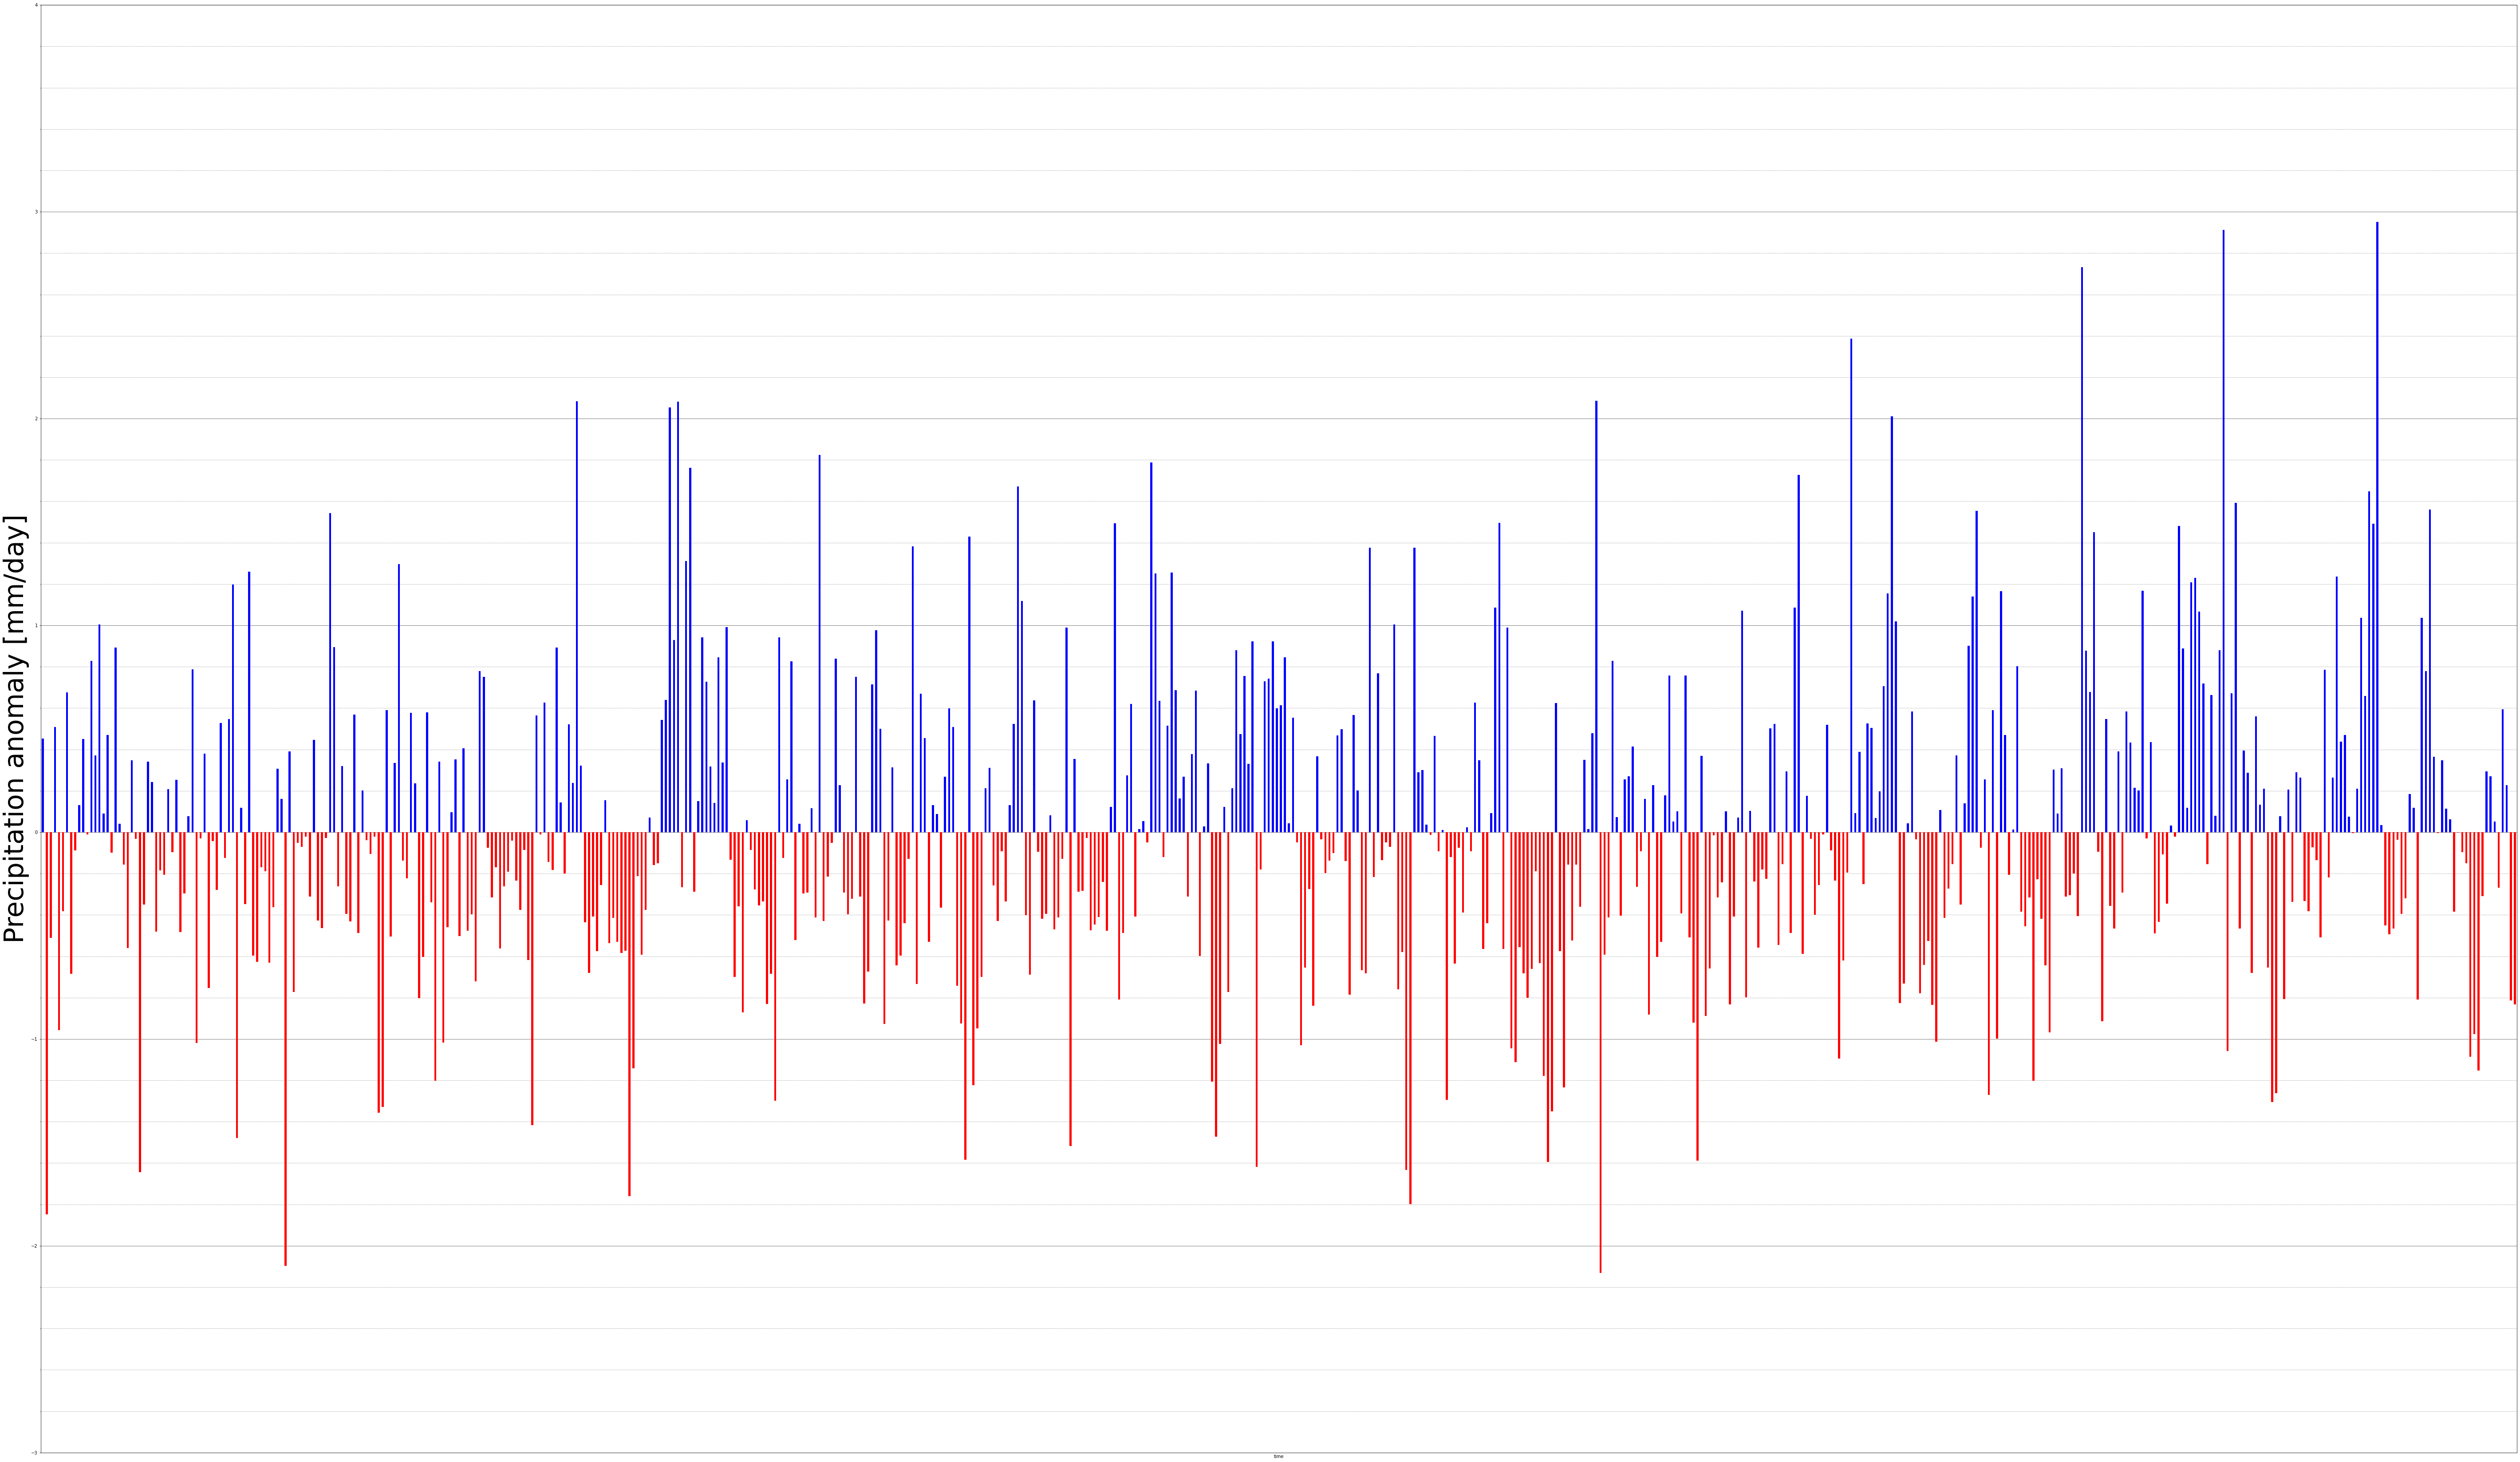

In [9]:
# still tryin to get a nice bar graph
# plot the precipitation anomalies for each month throughout the time period
# need to make the figure size really big so that all data points are included
rain_series = pr_anom_mon.sel(time=slice('1850-01','1900-12')).mean(dim=('lat','lon')).to_series() # convert to series so I can make a bar graph, but then I think it might be elimating data here

f = plt.figure(figsize=(100, 60))

ax = f.add_subplot(111)

#subplot1
rain_series.where(rain_series>0).plot.bar(ax=ax, color = 'blue')
rain_series.where(rain_series<0).plot.bar(ax=ax, color = 'red')
# add gridlines
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax.minorticks_on() # need this line in order to get the minor grid lines 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# axis labels and limits
ax.set_xticks([]) #disable xticks
ax.set_ylabel('Precipitation anomaly [mm/day]', fontsize=60)
ax.set_ylim(ymin = -3, ymax = 4)

(-3.0, 5.0)

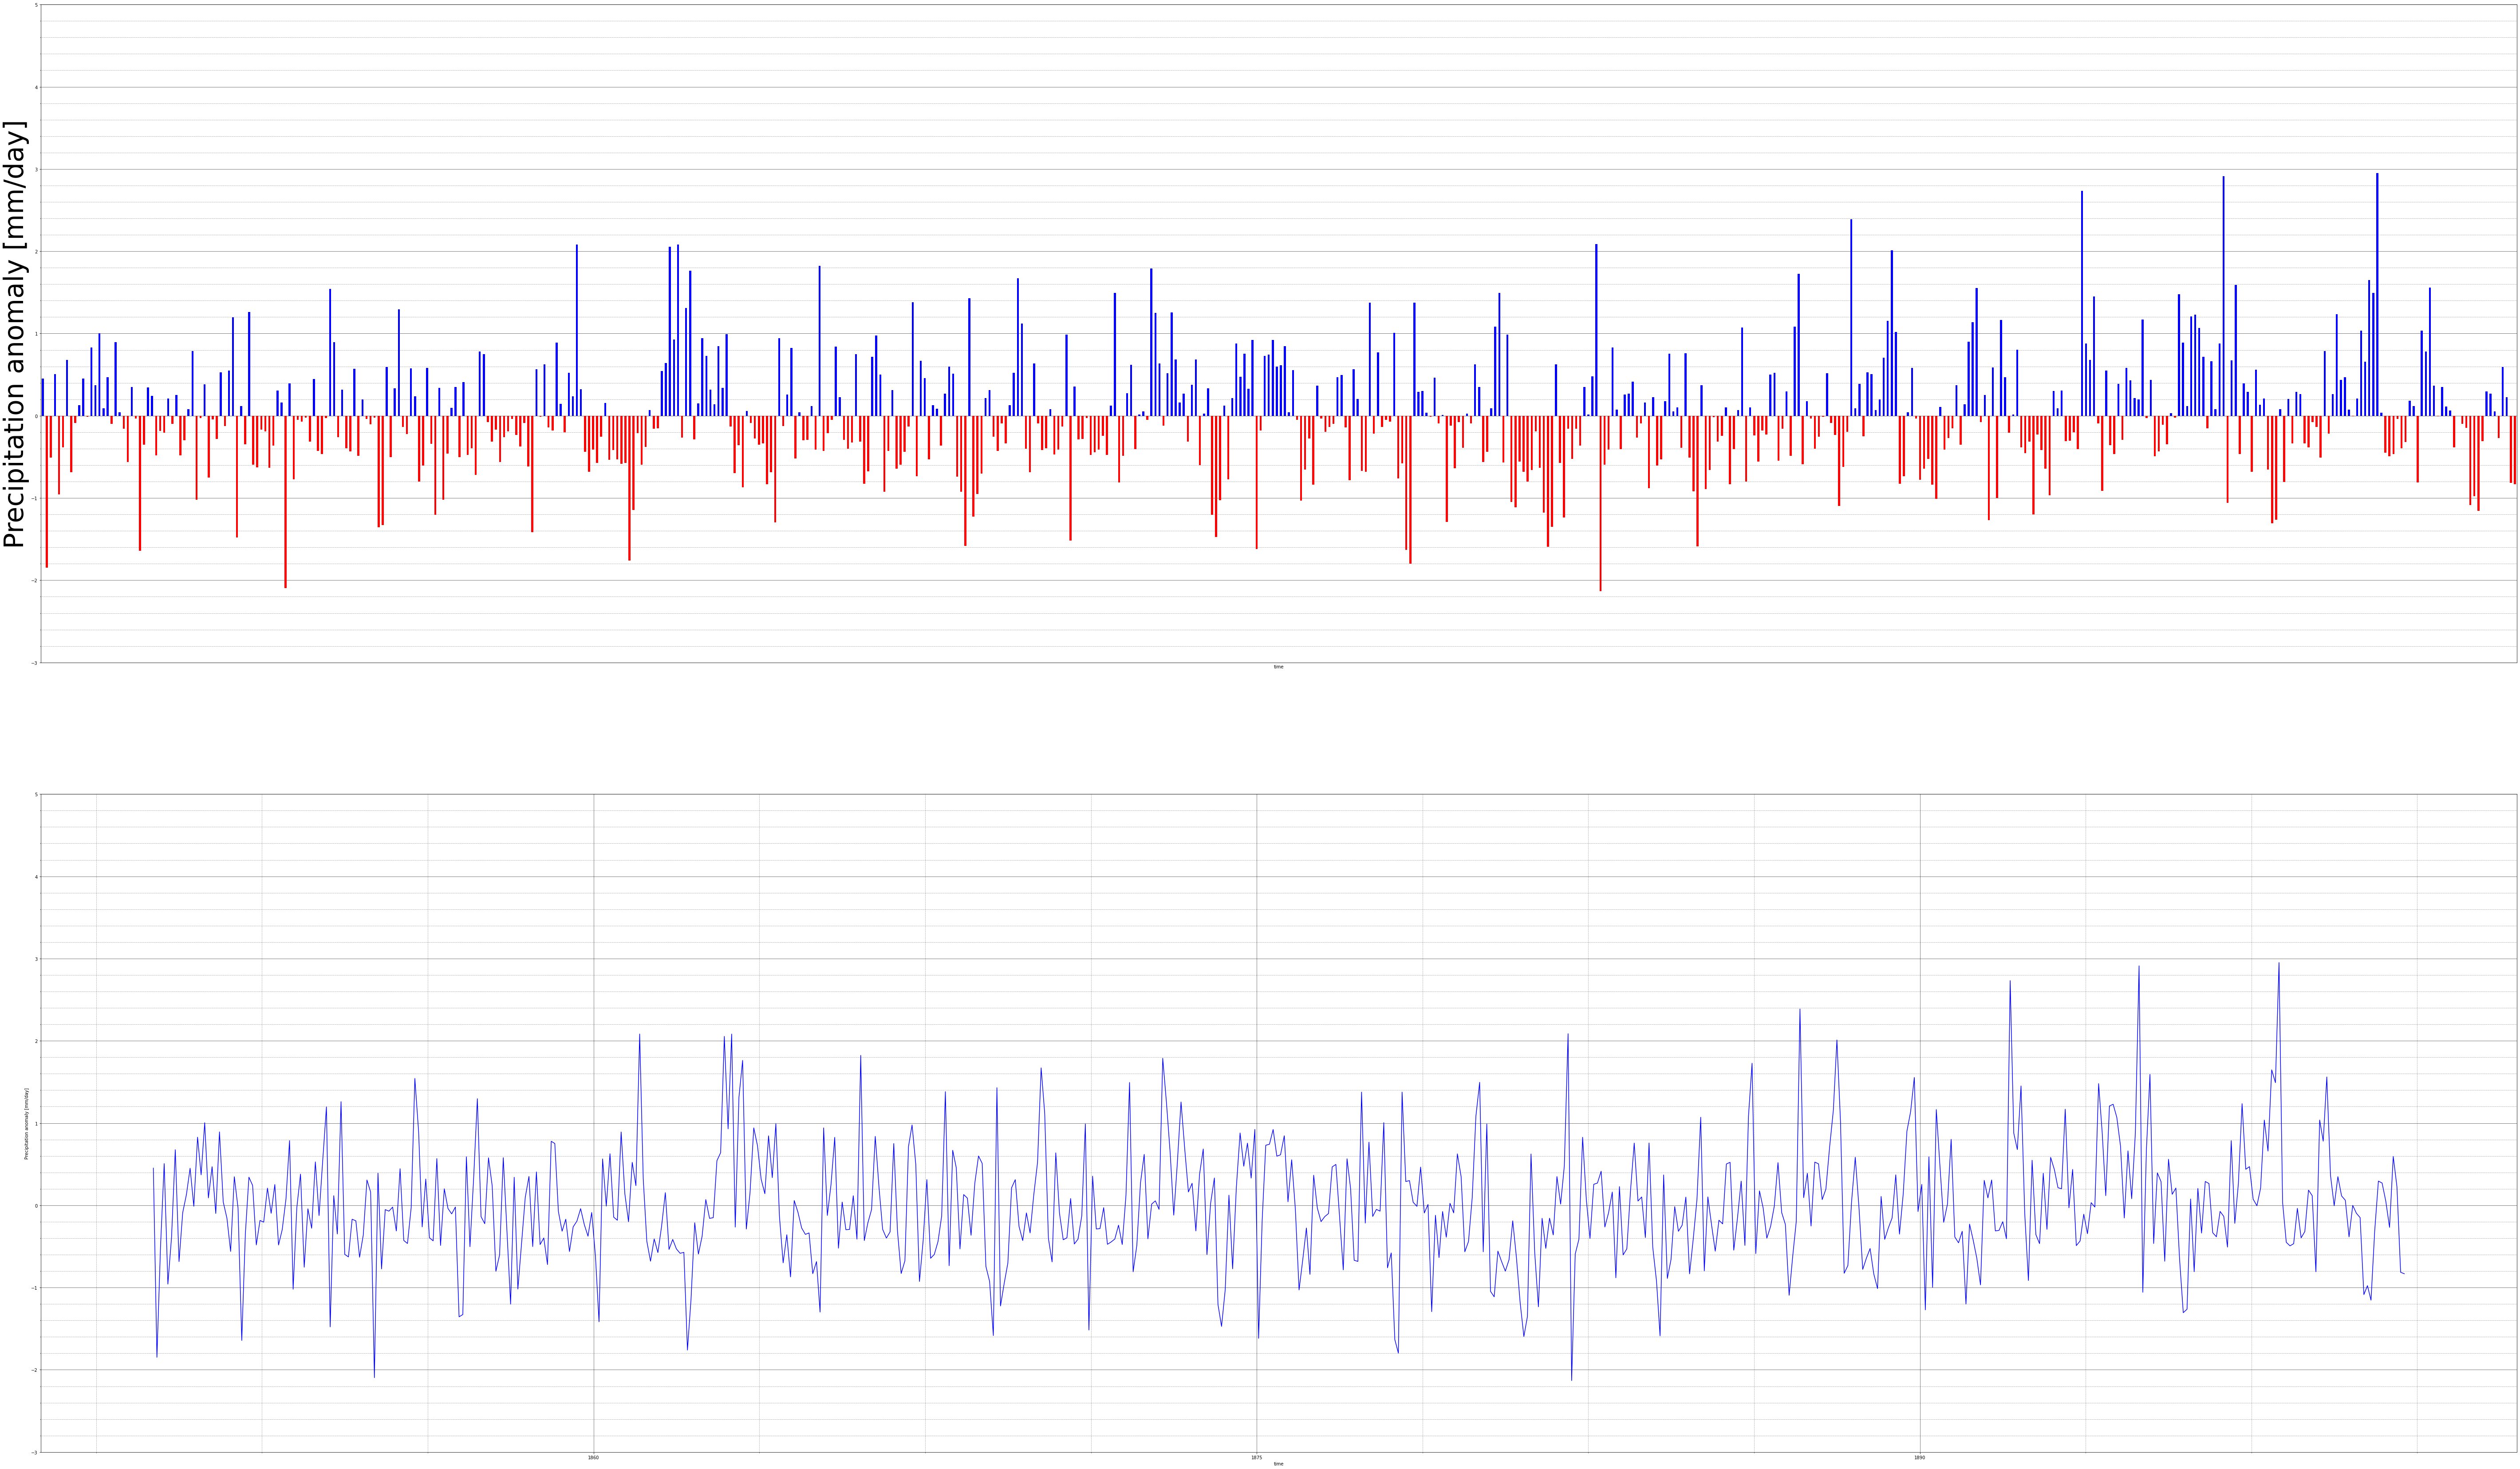

In [10]:
# still tryin to get a nice bar graph
# plot the precipitation anomalies for each month throughout the time period
# need to make the figure size really big so that all data points are included
rain_series = pr_anom_mon.sel(time=slice('1850-01','1900-12')).mean(dim=('lat','lon')).to_series() # convert to series so I can make a bar graph, but then I think it might be elimating data here

f = plt.figure(figsize=(100, 60))

ax = f.add_subplot(211)
ax2 = f.add_subplot(212)

#subplot1
rain_series.where(rain_series>0).plot.bar(ax=ax, color = 'blue')
rain_series.where(rain_series<0).plot.bar(ax=ax, color = 'red')
# add gridlines
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax.minorticks_on() # need this line in order to get the minor grid lines 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# axis labels and limits
ax.set_xticks([]) #disable xticks
ax.set_ylabel('Precipitation anomaly [mm/day]', fontsize=60)
ax.set_ylim(ymin = -3, ymax = 5)

#subplot 2
rain_series2 = pr_anom_mon.sel(time=slice('1850-01','1900-12')).mean(dim=('lat','lon'))

rain_series2.plot(ax=ax2, color = 'blue')
# add gridlines
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax2.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax2.minorticks_on() # need this line in order to get the minor grid lines 
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# axis labels and limits
#ax.set_xticks([]) #disable xticks
ax2.set_ylabel('Precipitation anomaly [mm/day]')
ax2.set_ylim(ymin = -3, ymax = 5)

In [11]:
print(rain_series)

time
1850-01-16 12:00:00    0.452296
1850-02-15 00:00:00   -1.848031
1850-03-16 12:00:00   -0.510676
1850-04-16 00:00:00    0.507597
1850-05-16 12:00:00   -0.958167
                         ...   
1900-08-16 12:00:00   -0.268404
1900-09-16 00:00:00    0.593684
1900-10-16 12:00:00    0.227903
1900-11-16 00:00:00   -0.814238
1900-12-16 12:00:00   -0.832116
Name: pr, Length: 612, dtype: float64


In [12]:
print(pr_anom_mon.mean(dim=('lat','lon')))

<xarray.DataArray 'pr' (time: 1980)>
array([ 0.45229581, -1.84803131, -0.51067609, ...,  0.50128282,
        0.19186374,  0.03111551])
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12


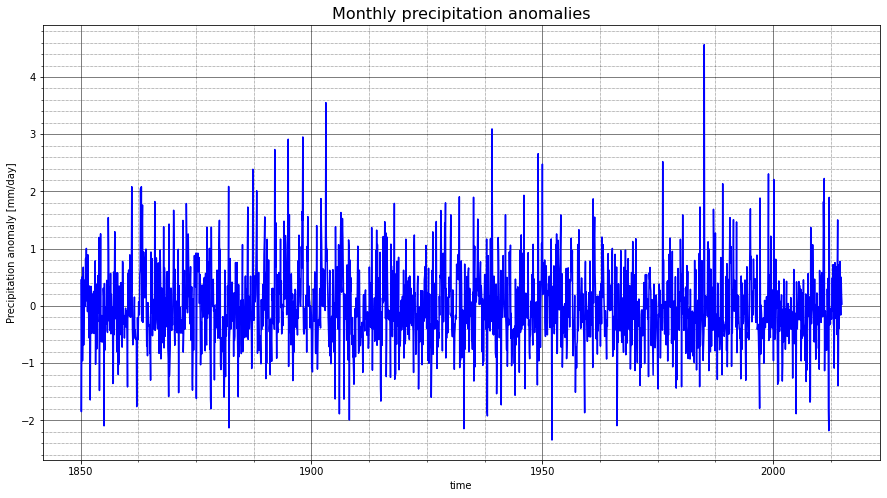

In [13]:
# plot the precipitation anomalies for each month throughout the time period
fig, ax = plt.subplots() # make a figure

pr_anom_mon.mean(dim=('lat','lon')).plot(color = 'blue', ax=ax) #plot the anomalies
plt.title('Monthly precipitation anomalies', fontsize=16)
plt.ylabel('Precipitation anomaly [mm/day]') # this overrides the label which comes on automatically using the xarray title

ax.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax.minorticks_on() # need this line in order to get the minor grid lines 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

fig.set_figheight(8) # these two parameters change the figure height and width 
fig.set_figwidth(15)
#fig.suptitle('example figure title', fontsize=16)


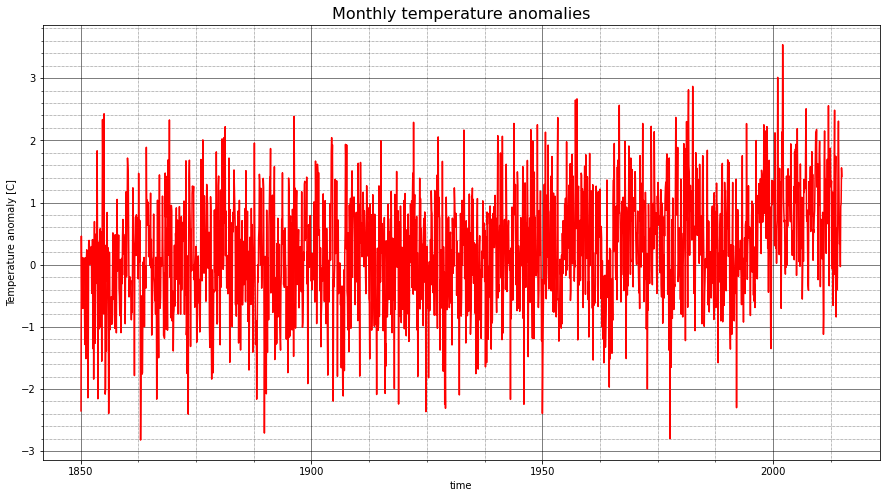

In [14]:
# plot the precipitation anomalies for each month throughout the time period
fig, ax = plt.subplots() # make a figure

ts_anom_mon.mean(dim=('lat','lon')).plot(color = 'red', ax=ax) #plot the anomalies
plt.title('Monthly temperature anomalies', fontsize=16)
plt.ylabel('Temperature anomaly [C]') # this overrides the label which comes on automatically using the xarray title

ax.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax.minorticks_on() # need this line in order to get the minor grid lines 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

fig.set_figheight(8) # these two parameters change the figure height and width 
fig.set_figwidth(15)
#fig.suptitle('example figure title', fontsize=16)

Text(0.5, 1.0, 'Monthly precipitation anomalies')

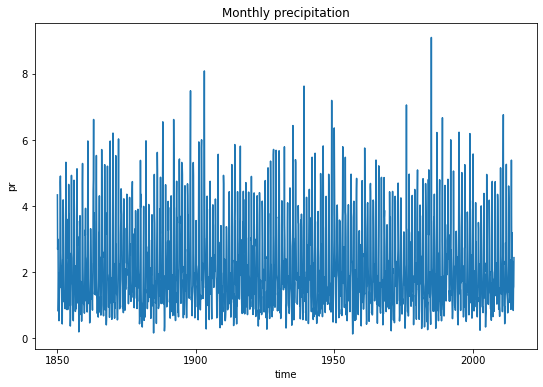

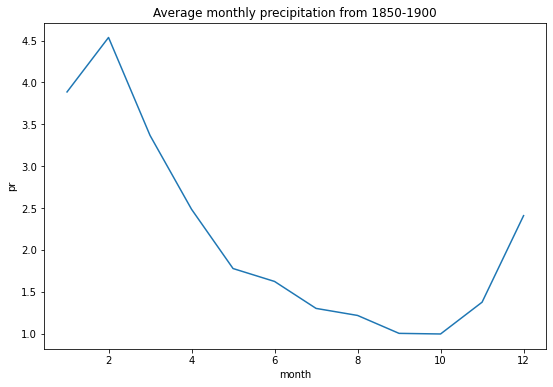

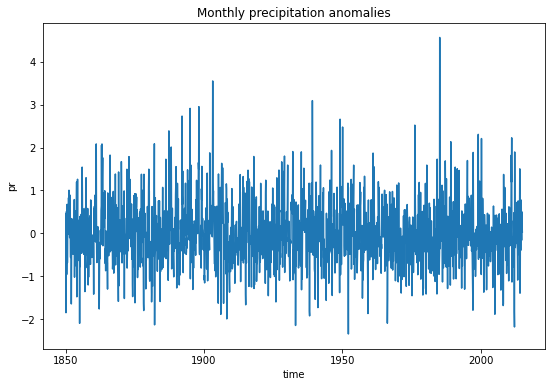

In [15]:
# just chekcing the climatology and anomalies are being calculated correctly
pr_aus_mon.mean(dim=('lat','lon')).plot(size=6)
plt.title('Monthly precipitation')
pr_aus_clim.mean(dim=('lat','lon')).plot(size=6)
plt.title('Average monthly precipitation from 1850-1900')
pr_anom_mon.mean(dim=('lat','lon')).plot(size=6)
plt.title('Monthly precipitation anomalies')


In [16]:
# these next few cells are to calculate seasonal anomalies
# first I need to define a new coordinate (seasonyear) so that december gets counted with the adjoining jan and feb
seasonyear_pr = (pr_ds.time.dt.year + (pr_ds.time.dt.month//12)) #
pr_ds.coords['seasonyear'] = seasonyear_pr
seasonyear_ts = (ts_ds.time.dt.year + (ts_ds.time.dt.month//12))
ts_ds.coords['seasonyear'] = seasonyear_ts

In [17]:
# define function to calculate the seasonal mean:
def seasonal_mean(data):
    return data.groupby('time.season').mean()

In [18]:
# group data into seasons and calculate the seasonal mean for each year in the dataset 
pr_yearly_seasonal = pr_ds.groupby('seasonyear').apply(seasonal_mean)
ts_yearly_seasonal = ts_ds.groupby('seasonyear').apply(seasonal_mean)

In [19]:
#then you can select a season:
pr_djf = pr_yearly_seasonal.sel(season='DJF')
# calculate the mean climatology along each season for the time period 1850-1900
pr_clim_seasonal = pr_yearly_seasonal.sel(seasonyear=slice('1850-01','1900-12')).mean(dim='seasonyear')
ts_clim_seasonal = ts_yearly_seasonal.sel(seasonyear=slice('1850-01','1900-12')).mean(dim='seasonyear')
#calculate the anomaly and extract the pr variable out of the xarray so pr_anom_seasonal is not an xarray
pr_anom_seasonal = (pr_yearly_seasonal.pr - pr_clim_seasonal.pr)*86400 # convert units again to mm/day
ts_anom_seasonal = (ts_yearly_seasonal.ts - ts_clim_seasonal.ts) # anomaly so no need to change temp units


In [20]:
# select the anomaly for each season
# precipitation
pr_anom_djf = pr_anom_seasonal.sel(season = 'DJF')
pr_anom_mam = pr_anom_seasonal.sel(season = 'MAM')
pr_anom_jja = pr_anom_seasonal.sel(season = 'JJA')
pr_anom_son = pr_anom_seasonal.sel(season = 'SON')

# temperature
ts_anom_djf = ts_anom_seasonal.sel(season = 'DJF')
ts_anom_mam = ts_anom_seasonal.sel(season = 'MAM')
ts_anom_jja = ts_anom_seasonal.sel(season = 'JJA')
ts_anom_son = ts_anom_seasonal.sel(season = 'SON')

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-4.99972820e-01, -3.99972826e-01, -2.99972832e-01, -1.99972823e-01,
        -9.99728292e-02,  2.71706012e-05,  1.00027174e-01,  2.00027168e-01,
         3.00027162e-01,  4.00027156e-01,  5.00027180e-01], dtype=float32),
 <a list of 10 Patch objects>)

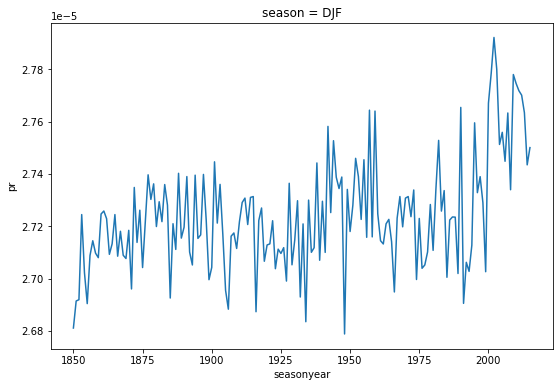

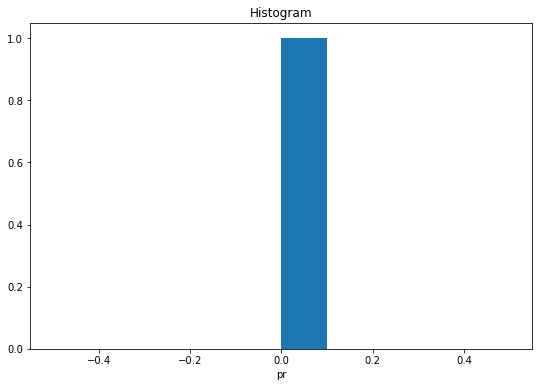

In [21]:
# again do some plots so I can check it's calculating right 
pr_djf = pr_yearly_seasonal.pr.sel(season='DJF')
pr_djf.mean(dim=('lat','lon')).plot(size=6)
pr_clim_djf = pr_clim_seasonal.pr.sel(season='DJF')
pr_clim_djf.mean(dim=('lat','lon')).plot(size=6)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 0.98, 'Seasonal precipitation anomalies')

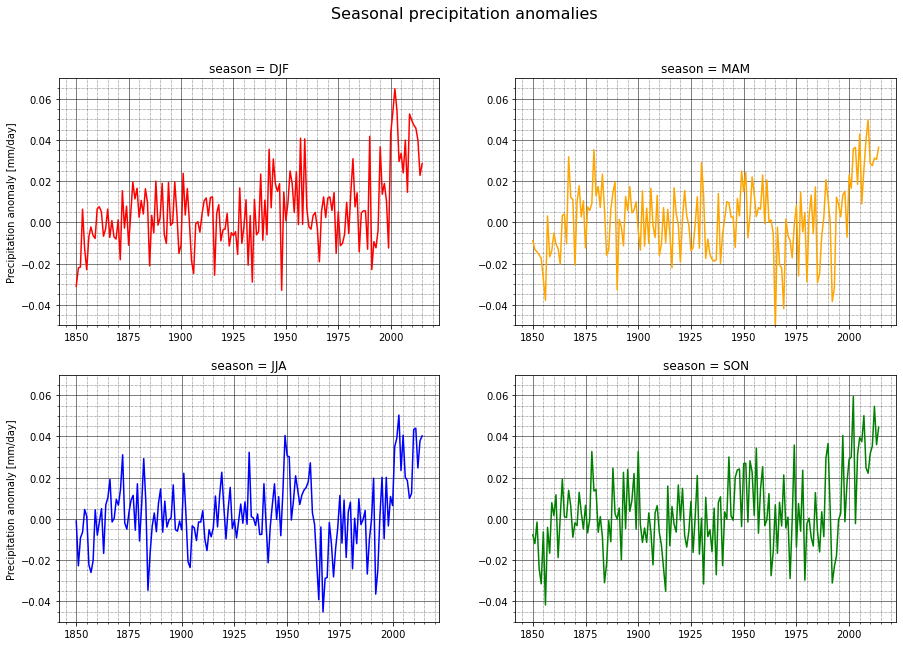

In [22]:
# make a subplot for the graphs
# if you do subplots this way then I can adjust the size of them

f = plt.figure(figsize=(15,10))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

#subplot 1 DJF
pr_anom_djf.mean(dim=('lat','lon')).plot(ax=ax, color ='red')
# add gridlines
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax.minorticks_on() # need this line in order to get the minor grid lines 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# change axis labels
ax.set(xlabel=None)
ax.set(ylabel='Precipitation anomaly [mm/day]')
# set axis limits
ax.set_ylim(ymin= -0.05, ymax=0.07)
#ax.set_xlim(self, bottom=None, top=None, emit=True, auto=False, *, ymin=None, ymax=None)

# subplot 2 MAM
pr_anom_mam.mean(dim=('lat','lon')).plot(ax=ax2, color='orange')
# add gridlines
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax2.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax2.minorticks_on() # need this line in order to get the minor grid lines 
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# change axis labels
ax2.set(xlabel=None)
ax2.set(ylabel=None)
# set axis limits
ax2.set_ylim(ymin= -0.05, ymax=0.07)

# subplot 3 JJA
pr_anom_jja.mean(dim=('lat','lon')).plot(ax=ax3, color='blue')
# add gridlines
ax3.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax3.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax3.minorticks_on() # need this line in order to get the minor grid lines 
ax3.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# change axis labels
ax3.set(xlabel=None)
ax3.set(ylabel='Precipitation anomaly [mm/day]')
# set axis limits
ax3.set_ylim(ymin= -0.05, ymax=0.07)

# subplot 4 SON
pr_anom_son.mean(dim=('lat','lon')).plot(ax=ax4, color='green')
# add gridlines
ax4.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax4.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax4.minorticks_on() # need this line in order to get the minor grid lines 
ax4.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# change axis labels
ax4.set(ylabel=None)
ax4.set(xlabel=None)
# set axis limits
ax4.set_ylim(ymin= -0.05, ymax=0.07)


f.suptitle('Seasonal precipitation anomalies', fontsize=16)
#f.set_figheight(5) # these two parameters change the figure height and width 
#f.set_figwidth(15)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 0.98, 'Seasonal temperature anomalies')

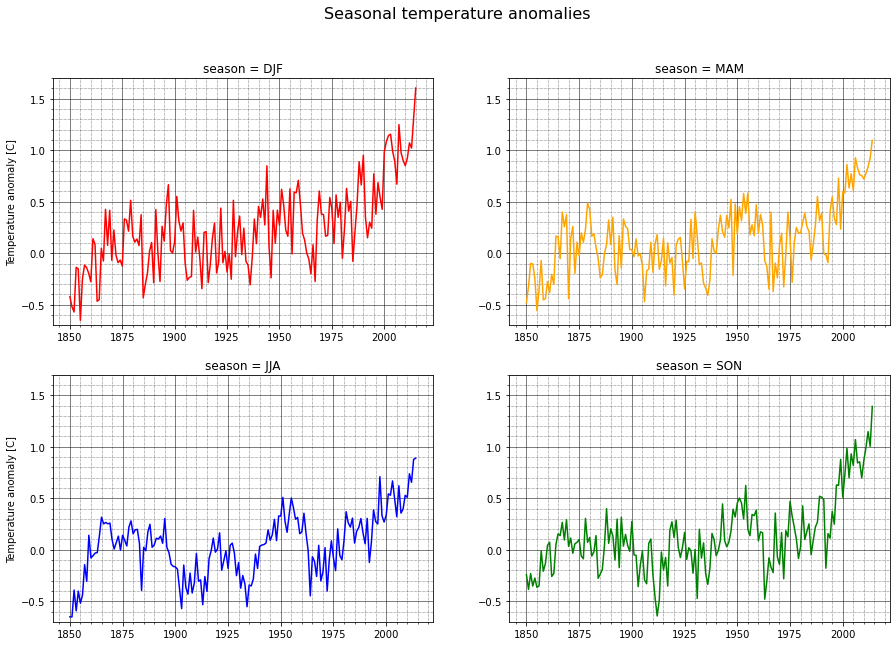

In [23]:
# seasonal temperature anomalies from 1850-2014 using a climatology from 1850-1900

f = plt.figure(figsize=(15,10))
ax = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

#subplot 1 DJF
ts_anom_djf.mean(dim=('lat','lon')).plot(ax=ax, color ='red')
# add gridlines
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax.minorticks_on() # need this line in order to get the minor grid lines 
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# change axis labels
ax.set(xlabel=None)
ax.set(ylabel='Temperature anomaly [C]')
# set axis limits
ax.set_ylim(ymin = -0.7, ymax = 1.7)
#ax.set_xlim(self, bottom=None, top=None, emit=True, auto=False, *, ymin=None, ymax=None)

# subplot 2 MAM
ts_anom_mam.mean(dim=('lat','lon')).plot(ax=ax2, color='orange')
# add gridlines
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax2.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax2.minorticks_on() # need this line in order to get the minor grid lines 
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# change axis labels
ax2.set(xlabel=None)
ax2.set(ylabel=None)
# set axis limits
ax2.set_ylim(ymin = -0.7, ymax = 1.7)

# subplot 3 JJA
ts_anom_jja.mean(dim=('lat','lon')).plot(ax=ax3, color='blue')
# add gridlines
ax3.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax3.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax3.minorticks_on() # need this line in order to get the minor grid lines 
ax3.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# change axis labels
ax3.set(xlabel=None)
ax3.set(ylabel='Temperature anomaly [C]')
# set axis limits
ax3.set_ylim(ymin = -0.7, ymax = 1.7)

# subplot 4 SON
ts_anom_son.mean(dim=('lat','lon')).plot(ax=ax4, color='green')
# add gridlines
ax4.grid(which='major', linestyle='-', linewidth='0.5', color='black') # customise major grid
ax4.set_axisbelow(True) # Don't allow the axis to be on top of your data, don't necessarily need this line
ax4.minorticks_on() # need this line in order to get the minor grid lines 
ax4.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# change axis labels
ax4.set(ylabel=None)
ax4.set(xlabel=None)
# set axis limits
ax4.set_ylim(ymin = -0.7, ymax = 1.7)


f.suptitle('Seasonal temperature anomalies', fontsize=16)
#f.set_figheight(5) # these two parameters change the figure height and width 
#f.set_figwidth(15)